In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"

data = blood_transfusion.copy()
target = data.pop(target_name)

In [2]:
blood_transfusion.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


In [3]:
target.nunique()

2

In [5]:
target.value_counts(normalize=True)

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

In [6]:
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_val_score

dummy_classifier = DummyClassifier(strategy='most_frequent')

scores_dummy_classifier = cross_val_score(
    dummy_classifier,
    data,
    target,
    cv=10,
)

print(scores_dummy_classifier.mean())

0.762054054054054


In [7]:
scores_dummy_classifier_balanced = cross_val_score(
    dummy_classifier,
    data,
    target,
    cv=10,
    scoring='balanced_accuracy',
)

print(scores_dummy_classifier_balanced.mean())

0.5


Computing distances on scaled or un-scaled data takes similar time but the resulting distance values could be very different and therefore ordering of which sample is a closest neighbor to which sample also. For instance: if you have two variables A and B where A has values which vary between 0 and 1000000 (e.g. the price of a house in euros) and B is a variable that varies between 0 and 30 (e.g. the average outside air temperature in Celsius degrees), then computing distances between rows of such a database will be mostly impacted by the differences in values of the A column and the values of B column will be comparatively ignored. If one applies StandardScaler to such a database, both the values of A and B will be approximately between -3 and 3 and the neighbor structure will be impacted by both variables.

In [8]:
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(   # both with default hyperparameters
    StandardScaler(),
    KNeighborsClassifier()
)

In [11]:
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

From the inspection of the parameters, it appears that the number of neighbors considered when predicting with the k-nearest neighbors has a default value of **K=5**.

In [20]:
from sklearn.model_selection import cross_validate

scores_KNN_balanced = cross_validate(
    pipeline,
    data,
    target,
    cv=10,
    scoring='balanced_accuracy',
    return_train_score=True,
)

cv_results = pd.DataFrame(scores_KNN_balanced)
print(
    f"The average train score is {cv_results['train_score'].mean():.2f}, while the average test score is {cv_results['test_score'].mean():.2f}"
)

The average train score is 0.70, while the average test score is 0.53


The training scores are systematically higher than the testing scores, therefore the model clearly overfits.

In [21]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]

train_scores, test_scores = validation_curve(
    pipeline,
    data,
    target,
    param_name="kneighborsclassifier__n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="balanced_accuracy",
)

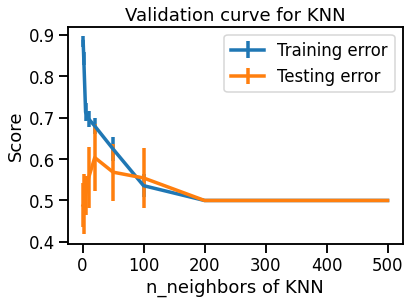

In [24]:
import matplotlib.pyplot as plt

plt.errorbar(
    param_range,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    label='Training error'
)
plt.errorbar(
    param_range,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    label='Testing error'
)
plt.legend()

plt.xlabel("n_neighbors of KNN")
plt.ylabel("Score")
_ = plt.title("Validation curve for KNN")

It looks lile both curves are getting closer between n=20 and n=50, but clearly the model underfits for values between 100 and 500.
>Underfitting happens when the gap between train and test scores is low and that both scores are low. When n_neighbors is high, underfitting occurs. The model lacks expressivity because it always considers the majority class of a large number of data points. Its prediction tends to be always the same, irrespective of the test point of interest.

>Overfitting happens when the gap between train and test scores is high and that the test score is low. When n_neighbors is low, the model looks at small number of data points around the test points of interest. In this case the model is too flexible: it is sensible to noise rather than the underlying structure of the data.

>Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.
>Considering an intermediate value for n_neighbors makes it possible to limit overfitting by averaging out the influence of a few noisy samples. On the other hand, the model can also avoid underfitting by focusing its decision on the details of a region of interest close to the test sample. The optimum value for n_neighbors is typically very dataset dependent and can be influenced by the choice of the distance metric, the scaling of the features, the presence of noisy sample, the balance between classes.
>Finally note while k-nearest neighbors is useful baseline, it can be to slow to predict on large datasets with many samples and features and practitioners would instead favor other models such as gradient boosted trees for instance. On the particular dataset used for this quiz, the best accuracy achieved by the nearest neighbors model does not seem to be high enough to make it useful.